![](header.jpg)

# EX8029 Stereo Camera

Kevin J. Walchko, Phd

20 Nov 2018

---

The EX8029 Stereo Camera from eYs3D is a depth-map imager controller and patterned IR illuminator capable of both color and point map output modes. Thanks to its dual cameras, this Stereo Camera is ideally used in applications involving motion and gesture control, field mapping, and 3D scanning. The best part about this module is the fact that it has been designed to be as straight forward and easy to use as possible for a stereo camera. Simply plug in the included USB 3.0 cable download the required files and start seeing things through the eyes of your new camera!

![](pics/camera.jpg)

## Specs

- Controller: eSP870U
- IR pattern Illuminator Wavelength: 850nm +/-10 nm
- IR pattern Illuminator Number of Features: >10,000
- Lens: 1LS1022G by AOET
- Image Sensor: OV9714 by OVT
- USB Bus Power: 
    - USB3: 5V/900mA
    - USB2: 5V/500mA
- PC Connection: 
    - USB3: get left/right color image @ 720p and depth
    - USB2: get left color image @ 640p and depth
- Operating Current With Patterned IR Illuminator: up to 350mA
- Operating Current Without Patterned IR Illuminator: up to 280mA
- Suspend Current: up to 15mA

## OS Support

- Windows 10: only get left image @ 640x480, no depth image
- macOS: only get stereo pair, no depth image
- Linux: (USB2/RaspberryPi)
    - 0: left image @ 640x480 BGR
    - 1: depth @ 480x320 YUYV

## References

- [eYs3D Stereo Camera - EX8029 datasheet](docs/EX8029_DataSheet_rev1.0_20170114.pdf)
- [Buy from Sparkfun.com](https://www.sparkfun.com/products/14726)
- [Stereo rectification tutorial](https://vgg.fiit.stuba.sk/2015-02/2783/)
- [OpenCV tutorial on depth maps](https://docs.opencv.org/3.4.3/dd/d53/tutorial_py_depthmap.html)
- [OpenCV tutorial on pose estimation](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_pose/py_pose.html)
- [caltech camera calibration docs](http://www.vision.caltech.edu/bouguetj/calib_doc/htmls/example.html)
- Some of the pictures came from O'Reilly "Learning OpenCV"

## Pinhole Camera Model

![](pics/pinhole_camera_model.png)

\begin{eqnarray}
  s p = A[R|t]P \\
  s \begin{bmatrix} u\\ v\\ 1 \end{bmatrix} = 
  \begin{bmatrix}
    f_x & 0 & c_x \\
    0 & f_y & c_y \\
    0 & 0 & 1
  \end{bmatrix}
  \begin{bmatrix} R_{3x3} & t_{xyz} \end{bmatrix}
  \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix}
\end{eqnarray}

where:

- P(X, Y, Z) are the coordinates of a 3D point in the world coordinate space
- p(u, v) are the coordinates of the projection point in pixels
- A is a camera matrix, or a matrix of **intrinsic** parameters (think internal parameters)
- (cx, cy) is a principal point that is usually at the image center
- fx, fy are the focal lengths expressed in pixel units
- [R|t] are the **extrinsic** parameters (think external parameters)
- s is a scale factor

## Focal Length

There is only one focal length ($f$) for a camera and it is the distance between the focal point and the image plane. However, for computer vision, $f_x = f \cdot s_x$ and $f_y = f \cdot s_y$ where $s_x$ and $s_y$ are the size of your image plane in pixels (note, this is probably not the size of your image). So $f_y = f_x \cdot a$ where $a$ is the aspect ratio of your image (width/height).

OpenCV will output the camera's focal length in pixels ($f_{px}$), this example will give you an idea for how to determine if the calibrated answer is correct or not. Also, due to mechanical misalignments during the camera building process, the answer below is not what OpenCV will produce. The answer below is an ideal answer based off of a datasheet, but you should get something relatively close.

$$
f_{px} = f_{mm}*\frac{resolution_{px}}{sensorSize_{\mu m}}
$$

| Parameter | Value |
|---|---|
| Sensor | OV9714 |
| Active Array Size | 1296 x 812 |
| Image Area | 3936 um x 2460 um |
| Camera Focal Length | 3.11 mm |

In [41]:
fx = 3.11e-3*1296/(3936e-6)
fy = 3.11e-3*812/(2460e-6)
print('Focal length (x,y) in pixels: {:.2f} {:.2f}'.format(fx, fy))

Focal length (x,y) in pixels: 1024.02 1026.55


# Calibrating Stereo Cameras

![](pics/calib_pattern.jpg)

We need to estimate some camera parameters, both internal and external. Basic process:

1. For a series of images, use `cv2.findMarkers()` to find your calibration target's pattern (`objpts`) in the image (`imgpts`) for each gray scale image
1. You can use `cv2.cornerSubPix()` to refine your results
1. Use `cv2.calibrateCamera()` to get the left/right camera intrinsic parameters
1. Use `cv2.stereoCalibrate()` to get the system extrinsic parameters

## Intrinsics (Internal)

- **Camera Matrix (A):** this holds the internal camera parameters (see pinhole model above)
    - **focal length (fx,fy):** measured in pixels for both the x and y direction
    - **principle point (cx,cy):** is the center of the image measured in pixels for both the x and y direction. Due to mechanical misalignment during manufacturing of the camera, it probably won't be dead center of your image but off a little. Better, higher quality camera, less error.

## Extrinsics (External)

![](pics/stereo.png)

These are parameters that releate how the cameras are positioned/oriented in the 3d world.

- **Rotation (R):** How the cameras are orientated between each other in angular space
- **Translation (T):** how the cameras are positioned (separated) in physical space (units will be meters, centimeters, milimeters, etc)
- **Essential Matrix (E):** contains the information about translation and rotation between the 2 cameras in global coordinates.
- **Fundamental Matrix (F):** contains the same information as E, but also contains intrinsics of both cameras so that we can relate the two cameras in pixel coordinates.

## [Fundamental Matrix (F)](https://en.wikipedia.org/wiki/Fundamental_matrix_(computer_vision))

![](pics/epipolar_geometry.png)

The fundamental matrix is a relationship between any two images of the same scene that constrains where the projection of points from the scene can occur in both images. Given the projection of a scene point into one of the images the corresponding point in the other image is constrained to a line (epipolar line), helping the search, and allowing for the detection of wrong correspondences. The relation between corresponding image points which the fundamental matrix represents is referred to as epipolar constraint, matching constraint, discrete matching constraint, or incidence relation.

- Correspondence: given a point x (left image) and the corresponding point x' (right image), F has the following property $x'^T F x = 0$
- Epipolar lines: the corresponding point for x (left) must lie along the line (l') in the right image: $l' = Fx$. Similarly, $l = F^Tx'$ for point x' (right).
- rank(F) = 2

## [Essential Matrix (E)](https://en.wikipedia.org/wiki/Essential_matrix)

Like F, E carries knowledge of the stereo setup, but it exists in normalized space, not pixel space.

\begin{eqnarray}
    \hat x' = R(\hat x -T) \\
    E = R[t]_x \\
    [t]_x = \begin{bmatrix} 
        0    & -T_z & T_y \\
        T_z  & 0    & -T_x \\
        -T_y & T_x  & 0
    \end{bmatrix}
\end{eqnarray}

where $[t]_x$ is often referred to as a skew matrix.

When we say normalized coordinates, we are saying they are normalized with respesct to the depth or Z coordinate.

\begin{eqnarray}
    \hat x = \begin{bmatrix} x & y & 1 \end{bmatrix}^T = \begin{bmatrix} X & Y & Z \end{bmatrix}^T \frac{1}{Z}
\end{eqnarray}

where (X,Y,Z) are in world coordinates and (x,y) are the normalized coordinates. 

Given image points in both cameras (with noise), the E can be estimated using a total least squares approach. This approach is commonly referred to as the [eight-point-algorithm](https://en.wikipedia.org/wiki/Eight-point_algorithm)

## F and E Relationship

- F can be thought of as a generalization of E
- For cameraMatrix A (left) and A' (right), $E = A'^TFA$ or $F = (A^T)^{-1} E A^{-1}$

## Rectifying Images

![](pics/stereo_undistort.jpg)

During camera manufacturing, small mechanical misalignments are produced which can effect stereo performance. To fix the image and make straight lines (think epipolar lines) straight again:

- `cv2.stereoRectify()` to produce necessary matricies
- Create distortion maps using `cv2.initUndistortRectifyMap()` for the left/right camera
- Undistort an image using `cv2.remap()` and the products from the above functions. The good thing, though, is the first 2 function can be called once so you have everything. Then, during run-time, you can just use `cv2.remap()`

## Calculating Disparity Maps

![](pics/disparity-2.png)

Objects closer to the stereo cameras will have larger disparity, meaning they will be found in different places in the two images. Conversly, objects farther way will have smaller disparity and will be found roughly in the same row/column of both images.

![](pics/disparity.png)

Stereo models like `cv2.StereoSGBM` or `cv2.StereoBM` can be used to find corresponding points in the image pair (left and right) and calculate the disparity between them (number of pixels). Instead of matching individual pixels, the stereo models tend to match blocks of pixels.

### Block Matching (BM)

[ref](https://docs.opencv.org/3.4.0/d9/dba/classcv_1_1StereoBM.html) 

The class computing stereo correspondence using the block matching algorithm, introduced and contributed to OpenCV by K. Konolige. Stereo algorithms tend not to match points (which is what the math above leads you to believe) but rather they match square blocks of pixels (e.g., 5x5, 7x7).

#### Params

- **numDisparities:** the disparity search range. For each pixel algorithm will find the best disparity from 0 (default minimum disparity) to numDisparities. The search range can then be shifted by changing the minimum disparity.
- **blockSize:** the linear size of the blocks compared by the algorithm. The size should be odd (as the block is centered at the current pixel). Larger block size implies smoother, though less accurate disparity map. Smaller block size gives more detailed disparity map, but there is higher chance for algorithm to find a wrong correspondence.

### Semi Global Block Matching (SGBM)

[ref](https://docs.opencv.org/3.4/d2/d85/classcv_1_1StereoSGBM.html#details)

The class implements the modified H. Hirschmuller algorithm that differs from the original one as follows:

- By default, the algorithm is single-pass, which means that you consider only 5 directions instead of 8. Set `mode=StereoSGBM::MODE_HH` in `StereoSGBM_create` to run the full variant of the algorithm but beware that it may consume a lot of memory.
- The algorithm matches blocks, not individual pixels. Though, setting blockSize=1 reduces the blocks to single pixels.
- Mutual information cost function is not implemented. Instead, a simpler Birchfield-Tomasi sub-pixel metric from is used. Though, the color images are supported as well.
- Some pre- and post- processing steps from K. Konolige algorithm StereoBM are included, for example: pre-filtering (`StereoBM::PREFILTER_XSOBEL` type) and post-filtering (uniqueness check, quadratic interpolation and speckle filtering).

#### Params

- **minDisparity:**	Minimum possible disparity value. Normally, it is zero but sometimes rectification algorithms can shift images, so this parameter needs to be adjusted accordingly.
- **numDisparities:**	Maximum disparity minus minimum disparity. The value is always greater than zero. In the current implementation, this parameter must be divisible by 16.
- **blockSize:**	Matched block size. It must be an odd number >=1 . Normally, it should be somewhere in the 3..11 range.
- **P1:**	The first parameter controlling the disparity smoothness. See below.
- **P2:**	The second parameter controlling the disparity smoothness. The larger the values are, the smoother the disparity is. P1 is the penalty on the disparity change by plus or minus 1 between neighbor pixels. P2 is the penalty on the disparity change by more than 1 between neighbor pixels. The algorithm requires P2 > P1 . See stereo_match.cpp sample where some reasonably good P1 and P2 values are shown, like:
    - P1: $8 \cdot numberImageChannels \cdot SADWindowSize \cdot SADWindowSize$
    - P2: $32 \cdot numberImageChannels \cdot SADWindowSize \cdot SADWindowSize$
- **disp12MaxDiff:**	Maximum allowed difference (in integer pixel units) in the left-right disparity check. Set it to a non-positive value to disable the check.
- **preFilterCap:**	Truncation value for the prefiltered image pixels. The algorithm first computes x-derivative at each pixel and clips its value by [-preFilterCap, preFilterCap] interval. The result values are passed to the Birchfield-Tomasi pixel cost function.
- **uniquenessRatio:**	Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct. Normally, a value within the 5-15 range is good enough.
- **speckleWindowSize:**	Maximum size of smooth disparity regions to consider their noise speckles and invalidate. Set it to 0 to disable speckle filtering. Otherwise, set it somewhere in the 50-200 range.
- **speckleRange:**	Maximum disparity variation within each connected component. If you do speckle filtering, set the parameter to a positive value, it will be implicitly multiplied by 16. Normally, 1 or 2 is good enough.
- **mode:**	Set it to StereoSGBM::MODE_HH to run the full-scale two-pass dynamic programming algorithm. It will consume O(W\*H\*numDisparities) bytes, which is large for 640x480 stereo and huge for HD-size pictures. By default, it is set to `False`.

## Calculating Depth Maps

Disparities maps (x-x') can be reprojected to 3d:

\begin{eqnarray}
    Z = \frac{fT_x}{x-x'}
\end{eqnarray}

During stereo calibration (`cv2.stereoCalibrate()`), there is a Q matrix which is produced. This can also reproject image points to world points using the `cv2.reprojectImageTo3d()`:

\begin{eqnarray}
    \begin{bmatrix}
        X & Y & Z & W
    \end{bmatrix}^T = Q \begin{bmatrix} x & y & d & 1 \end{bmatrix}^T \\
    Q = \begin{bmatrix}
        1 & 0 & 0 & -c_x \\
        0 & 1 & 0 & -c_y \\
        0 & 0 & 0 & f \\
        0 & 0 & -1/T_x & (c_x - c_x')/T_x
    \end{bmatrix}
\end{eqnarray}

Now the true 3D points are X/W, Y/W, and Z/W. If `CV_CALIB_ZERO_DISPARITY` is set, then $c_x = c_x'$ and the value in the lower right corner of Q is 0. Doing a little bit of algebra on the equations above leads you to:

\begin{eqnarray}
     Q \begin{bmatrix} x & y & d & 1 \end{bmatrix}^T = 
     \begin{bmatrix}
         \frac{-Tx (x - c_x)}{d} \\
         \frac{-Tx (y - c_y)}{d} \\
         \frac{-f T_x}{d}
     \end{bmatrix} = \begin{bmatrix} X & Y & Z \end{bmatrix}^T
\end{eqnarray}

If you look at the first equation for depth (Z) above and compare it to the last, they are the same. From a units stand point, for X, Y and Z and assuming the translation ($T_x$) units were meters (m), you end up with $\frac{m*px}{px} \Rightarrow m$. Thus your units have to be:

| Parameter               | Units  |
|-------------------------|--------|
| Baseline ($T_x$)        | meters |
| Focal length ($f$)      | pixels | 
| Principle point ($c_x$) | pixels |
| Disparity (d)           | pixels |

You can produce the 3D points using:

- `cv2.perspectiveTransform()`: this transforms an array of points to 3D space
- `cv2.reprojectImageTo3D()`: this transforms a whole disparity image

## Setup

In [17]:
import numpy as np
import cv2
import time
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [18]:
from camera_calibrate import Rectify, Markers

In [19]:
def draw(l, r, lines=True, thickness=1):
    """Display left/right stereo images and draw epipolar lines on image pairs"""
    n = np.hstack((l, r))
    if len(n.shape) < 3:
        n = cv2.cvtColor(n, cv2.COLOR_GRAY2RGB)
    if lines:
        h, w = n.shape[:2]
        for r in range(0, h, 20):
            cv2.line(n,(0,r), (w,r), (200,0,0), thickness)
    return n

In [20]:
# let's grab one image pair
img = cv2.imread('checkerboard-imgs/image-15.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
h,w = img.shape[:2]  # need to cut image in half
imgL = img[:,:w//2]
imgR = img[:,w//2:]

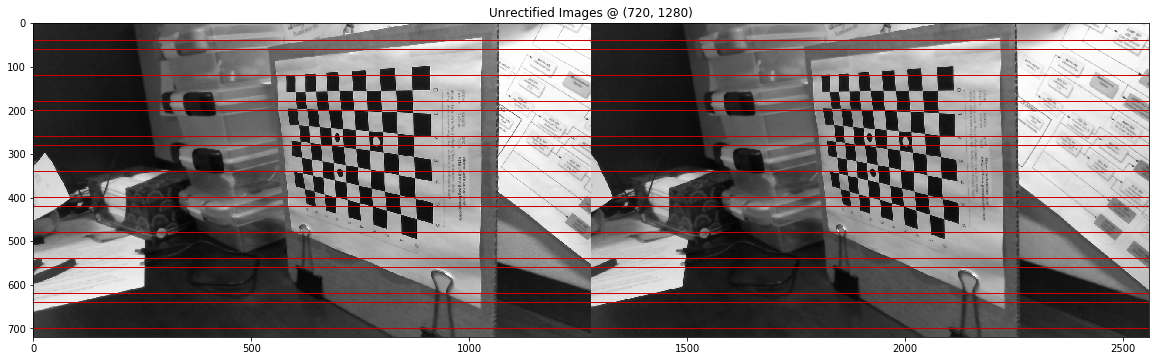

In [21]:
# looking at the uncalibrated images below, the camera 
# already has pretty good performance
plt.figure(figsize=(20,10))
plt.imshow(draw(imgL, imgR, lines=True), 'gray')
plt.title('Unrectified Images @ {}'.format(imgL.shape));

Text(0.5, 1.0, 'Rectified Stereo pair @ (720, 1280)')

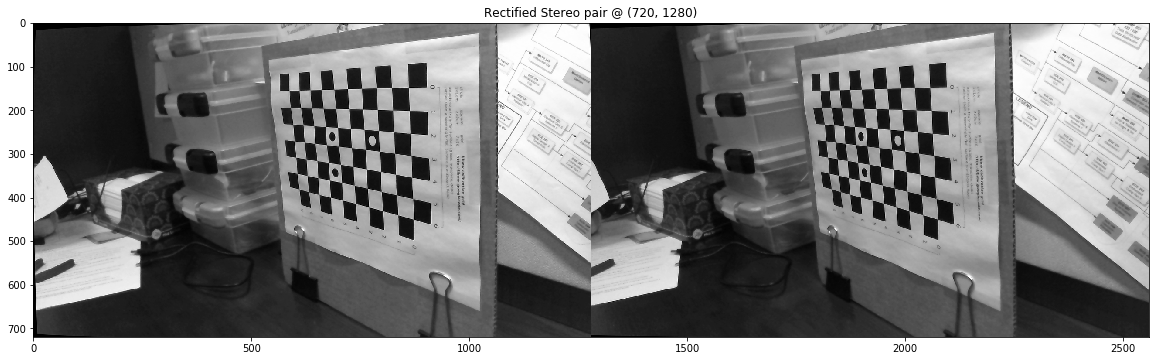

In [22]:
# let's load the camera model that was already created for this camera
# Note: look at the chessboard in the images, the paper target has some
# wrinkles in it which will adversly effect performance! I need to make
# a better target!!!
rc = Rectify("cb_camera_model.pickle")
imgLc, imgRc = rc.undistortStereo(imgL, imgR)
plt.figure(figsize=(20,10))
plt.imshow(draw(imgLc, imgRc, lines=False), 'gray')
plt.title('Rectified Stereo pair @ {}'.format(imgLc.shape))

In [23]:
# the camera spec says the baseline (Tx) is 31.1 mm and looking at the x
# element of the T matrix, we come up with 0.031 m which is pretty good!
print('Transation [m]:', rc.info['T'].transpose())

# our Q matrix follows the explanation above and looks t have correct 
# values
print('Q:', rc.Q)

Transation [m]: [[-0.03134446 -0.00025078 -0.00159318]]
Q: [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -5.74517601e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -3.56097889e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.15228688e+03]
 [ 0.00000000e+00  0.00000000e+00  3.18614187e+01 -0.00000000e+00]]


## Stereo Matching

In [24]:
# let's do some stereo matching!
if False:
    window_size = 3
    min_disp = 16
    num_disp = 112-min_disp
    stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
       numDisparities = num_disp, # Maximum disparity minus minimum disparity
       blockSize = 16,
       P1 = 8*3*window_size**2,  # parameters for disparity matching
       P2 = 32*3*window_size**2,
       disp12MaxDiff = 1,  # matching differences
       uniquenessRatio = 10,  # matching parameter
       speckleWindowSize = 50,  # filtering to remove speckles in an image
       speckleRange = 2
    )
elif False:
    stereo = cv2.StereoBM_create(
        numDisparities=16*16,
        blockSize=15)
else:
    maxdisp = 16*9
    mindisp = 16*3
    ndisp = maxdisp - mindisp
    blksize = 11
    window_size = 3*3
    stereo = cv2.StereoSGBM_create(numDisparities=ndisp, blockSize=blksize,
       P1 = 8*1*window_size**2,  # parameters for disparity matching
       P2 = 32*1*window_size**2,
       mode=True
    )
    
#     stereo = cv2.StereoSGBM_create(minDisparity=mindisp, numDisparities=ndisp, blockSize=blksize)

disparity = stereo.compute(imgLc,imgRc)

Text(0.5, 1.0, 'SGBM Disparity Map')

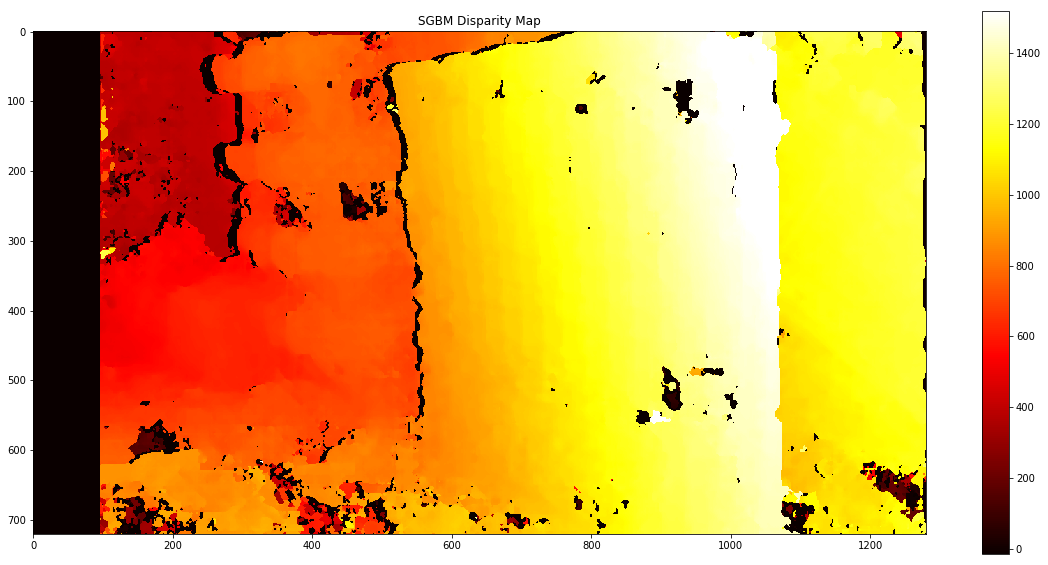

In [25]:
# let's plot our disparity map
plt.figure(figsize=(20,10))
plt.imshow(disparity, cmap='hot')
plt.colorbar();
plt.title('SGBM Disparity Map')

Notice how the disparity map above shows black segment. These are locations in 3D space that the left camera can see, but the right camera cannot see. This is typical of all stereo systems. If you have the time (or computation power), you can do better than this!

# Pretty Disparity Map

Like above, you see depth maps with holes in them due to the camera setup. Generally, depth maps are only calculated using the left camera as the origin. [Here](http://timosam.com/python_opencv_depthimage) we are following a python version of the OpenCV tutorials and creating another depth map based on the right camera. Then we filter and combine the two so holes are filled.

In [26]:
def prettyDisparity(imgL, imgR, stereo, **kwargs):
    """Creates a right stereo matcher based off the left stereo 
    matcher and then calculates a combined disparity map from
    both aspect in order to close up any wholes."""
    right_matcher = cv2.ximgproc.createRightMatcher(stereo)
     # FILTER Parameters
    lmbda = kwargs.get('lamda',80000)
    sigma = kwargs.get('signam',1.2)
    visual_multiplier = kwargs.get('mult',1.0)

    wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=stereo)
    wls_filter.setLambda(lmbda)
    wls_filter.setSigmaColor(sigma)

    displ = stereo.compute(imgL, imgR)  # .astype(np.float32)/16
    dispr = right_matcher.compute(imgR, imgL)  # .astype(np.float32)/16
    displ = np.int16(displ)
    dispr = np.int16(dispr)
    filteredImg = wls_filter.filter(displ, imgL, None, dispr)  # important to put "imgL" here!!!

    # need to normalize the image, so its values are between 0-255
    filteredImg = cv2.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);
    # need to convert back to 8b integer values
    filteredImg = np.uint8(filteredImg)
    return filteredImg

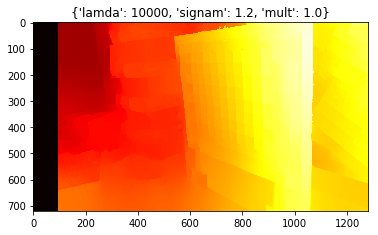

In [27]:
# this takes a lot more time, but makes a pretty picture
params = {
    'lamda': 10000,
    'signam': 1.2,
    'mult': 1.0
}
filteredImg = prettyDisparity(imgL, imgR, stereo, **params)
plt.imshow(filteredImg, cmap='hot')
plt.title('{}'.format(params));

Text(0.5, 1.0, '(720, 1280)')

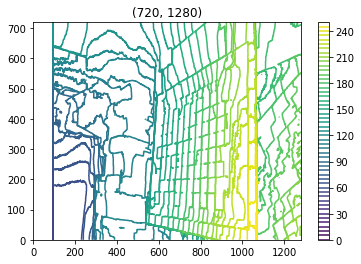

In [28]:
# let's make a contour plot for shits and giggles!
plt.contour(filteredImg, levels=range(0,255, 5))
plt.colorbar()
plt.title('{}'.format(filteredImg.shape))

# Recovering the Point Cloud [not working yet]

Now that we know the camera parameters and have a disparity map, we should be able to reproject this 2D disparity map back into 3D space.

**this doesn't work correctly right now**

In [31]:
class PLY(object):
    """Creates a file holding a 3D model"""
    ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''

    def write(self, fn, verts, colors):
        verts = verts.reshape(-1, 3)
        colors = colors.reshape(-1, 3)
        verts = np.hstack([verts, colors])
        with open(fn, 'w') as f:
            f.write((self.ply_header % dict(vert_num=len(verts))))
            np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

In [37]:
# disp = stereo.compute(imgL, imgR).astype(np.float32)/16
# mask = disp < 0
# disp[mask] = 0

# plt.figure()
# plt.imshow(disp)
# plt.colorbar()

# print('disp min/max:', disp.min(), disp.max())
# print('disp:', disp.shape)

# points = cv2.reprojectImageTo3D(disp, rc.Q, handleMissingValues=True)
# # colors = cv2.cvtColor(imgL, cv2.COLOR_GRAY2RGB)
# colors = imgL
# print('imgL', imgL.shape)

# print('[ Points {}]---------------------'.format(points.shape))
# print(' x min/max:', points[:,:,0].min(), points[:,:,0].max())
# print(' y min/max:', points[:,:,1].min(), points[:,:,1].max())
# print(' z min/max:', points[:,:,2].min(), points[:,:,2].max())
      

# print('colors:', colors.shape)

# print('-'*50)

# # mask = disp < 4
# # out_points = points[mask]
# # out_colors = colors[mask]
# # points[mask] = 200 # disp.max()


# # colors[mask]
# out_points = points
# o = points


# # mask = out_points < 1000
# # o = out_points[mask]
# # oc = out_colors[mask]


# print('filtered points min/max:', out_points.min(), out_points.max())
# print("filtered points:", out_points.shape)

# # o = out_points
# # # print(o[:,0])
# # fig = plt.figure(figsize=(20,10))
# # # ax = fig.gca(projection='3d')
# # # ax.plot_surface(o[:,0],o[:,1],o[:,2])
# # ax = fig.add_subplot(111, projection='3d')
# # ax.scatter(o[:,0],o[:,1],o[:,2])
# # # plt.show()

In [29]:
def getDistanceMap(img, disp, Q, sat=1000):
    # shouldn't be negative disparities, weed them out
    mask = disp < 2
    disp[mask] = 2
    
    points = cv2.reprojectImageTo3D(disp, Q, handleMissingValues=True)
    if len(img.shape) < 3:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # color = img.copy()  # since this only returns depth, color is useless
    
    # remove any really big distances
    z = points[:,:,2]
    z[z > sat] = sat
    
    # need to normalize the image, so its values are between 0-255
    z = cv2.normalize(z, None, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX)
    # need to convert back to 8b integer values
    z = np.uint8(z)
    return z

def getDistanceMap2(img, disp, Q, sat=1000):
    # shouldn't be negative disparities, weed them out
    mask = disp < 2
    disp[mask] = 2
    
    points = cv2.reprojectImageTo3D(disp, Q, handleMissingValues=True)
    if len(img.shape) < 3:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    color = img.copy()  # since this only returns depth, color is useless
    
    # remove any really big distances
    x = points[:,:,0]
    x[x > sat] = sat
    
    y = points[:,:,1]
    y[y > sat] = sat
    
    z = points[:,:,2]
    z[z > sat] = sat
    
    # need to normalize the image, so its values are between 0-255
#     z = cv2.normalize(z, None, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX)
    # need to convert back to 8b integer values
#     z = np.uint8(z)
    return points, color

In [39]:
# z = getDistanceMap(imgL, disp, rc.Q, 3)
# plt.imshow(z, cmap='hot');

In [41]:
# z = getDistanceMap(imgL, filteredImg, rc.Q, 4)
# plt.title('Distance Map')
# plt.imshow(z[:,100:], cmap='hot'); # clip the dead zone off

In [42]:
# pts, clrs = getDistanceMap2(imgL[:,100:], disp[:,100:], rc.Q, 3)

# # plt.figure(); plt.imshow(pts[:,:,0]); plt.colorbar()
# # plt.figure(); plt.imshow(pts[:,:,1]); plt.colorbar()
# # plt.figure(); plt.imshow(pts[:,:,2]); plt.colorbar()

# plt.contour(pts[:,:,0], pts[:,:,1], pts[:,:,2])

In [15]:
# ply = PLY()
# ply.write('out.ply', out_points, out_colors)

In [23]:
# ply = PLY()
# ply.write('cb.ply',pts,clrs)